In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# Any results you write to the current directory are saved as output.

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
from tqdm.autonotebook import tqdm

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [3]:
import os
root = '/kaggle/input/aptos2019-blindness-detection/'
train_img_path = os.path.join(root,'train_images')
train_path = os.path.join(root,'train.csv')
test_img_path = os.path.join(root,'test_images')
test_path = os.path.join(root,'test.csv')

In [4]:
import pandas as pd
train_data = pd.read_csv(train_path)
train_data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5d770f4e0>]],
      dtype=object)

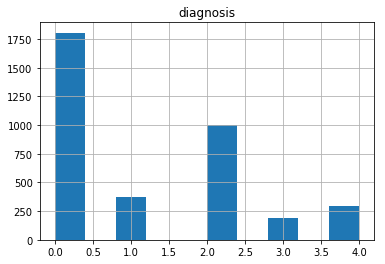

In [5]:
train_data.hist()

In [6]:
n_classes = train_data.diagnosis.nunique()

In [7]:
classes = train_data.diagnosis.unique()

In [8]:
train_data.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [9]:
train_data['id_code'] = train_data['id_code'].apply(lambda x:x+'.png')
train_data['diagnosis'] = train_data['diagnosis'].apply(lambda x:str(x))
train_data.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [10]:
train_data.dtypes

id_code      object
diagnosis    object
dtype: object

# Model

In [11]:
# define the size of our input data
sz=224

In [12]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(sz, sz, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

Using TensorFlow backend.


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

In [14]:
from keras import optimizers


'''
opt = Adam(lr=1e-4)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
'''
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train

In [15]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

In [16]:
#import keras
#from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.layers import Dropout, Flatten,Dense


import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image

# our batch size
bs=32

# No need for preprocess_fn as it will be handled in target_sz of the generator

import cv2
def preprocess_input(img):
    #return img/255#cv2.resize(img, (sz,sz))
    return img.astype('float32')/255

# preprocess_input is for VGG16 in our case
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True) 

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_batches = train_datagen.flow_from_dataframe(train_df, # The df
                                                  train_img_path, # Place on desk
                                                  x_col='id_code', # The column to get x
                                                  y_col='diagnosis', # The column to get y
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None, 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=True)



valid_batches = valid_datagen.flow_from_dataframe(val_df, 
                                                  train_img_path, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis', 
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None,#list(train_batches.class_indices),#classes, 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=False)

NbClasses = len(train_batches.class_indices)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [17]:
from sklearn.metrics import cohen_kappa_score
from keras.callbacks import Callback
class Kappa(Callback):
    
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_kappa': cohen_kappa_score(y_val, y_predict),
        })
        return

    def get_data(self):
        return self._data

In [18]:
import numpy as np


def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.

    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.

    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.

    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [19]:
X_val = []
y_val = []
s = 0
validation_steps = valid_batches.n // valid_batches.batch_size
print(validation_steps)
for b in tqdm(valid_batches):
#for s in validation_steps:
    #b = next(valid_batches)
    #print(s)
    if s > validation_steps: # to prevent looping forever
        break
    s+=1
    X_val.append(b[0])
    y_val.append(b[1])
X_val = np.concatenate(X_val)    
y_val = np.concatenate(y_val) 
   

22


In [20]:
print(X_val.shape)
print(y_val.shape)

(733, 224, 224, 3)
(733, 5)


In [21]:
#from sklearn.metrics import cohen_kappa_score

class QWKP(Callback):
    
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        #X_val, y_val = self.validation_data[0], self.validation_data[1]

        
        y_predict = np.asarray(model.predict(X_val))

        y_val_ = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)
        qwkp =  quadratic_weighted_kappa(y_val_, y_predict)
        print('Validation qwkp: ', str(qwkp))
        self._data.append({
            'val_kappa':qwkp,
        })
        return

    def get_data(self):
        return self._data

In [ ]:
epochs = 20

history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              #validation_data=valid_batches,
                              #validation_steps = valid_batches.n // valid_batches.batch_size,
                              callbacks=[QWKP()])

Epoch 1/20
 8/91 [=>............................] - ETA: 8:03 - loss: 1.3591 - acc: 0.4609

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualization

In [ ]:
# Get a sample image
b = next(valid_batches)
img = b[0][5]
print(img.shape)
plt.imshow(img)

In [ ]:
np.max(img)

In [ ]:
np.argmax(b[1][5])

In [ ]:
x = np.expand_dims(img, 0)
preds = model.predict(x)
idx = np.argmax(preds[0])
idx

In [ ]:
model.summary()

In [ ]:
from keras import backend as K
# This is the index entry in the prediction vector
output = model.output[:, idx]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer =model.layers[6] #model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [ ]:
heatmap.shape

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
import cv2


# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
#eatmap = np.uint8(heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.1 + img

# Save the image to disk
#cv2.imwrite('elephant_cam.jpg', superimposed_img)
plt.imshow(superimposed_img)

In [ ]:
from keras import backend as K
import cv2
def grad_CAM(model, layer, img):
    x = np.expand_dims(img, 0)
    preds = model.predict(x)
    idx = np.argmax(preds[0])

    
    # This is the index entry in the prediction vector
    output = model.output[:, idx]

    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    last_conv_layer =model.layers[layer] #model.get_layer('block5_conv3')

    # This is the gradient of the "african elephant" class with regard to
    # the output feature map of `block5_conv3`
    grads = K.gradients(output, last_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
    #plt.show()    
    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    #eatmap = np.uint8(heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.1 + img

    # Save the image to disk
    #cv2.imwrite('elephant_cam.jpg', superimposed_img)
    plt.imshow(superimposed_img)

# Submission

In [ ]:
submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))
submission.head()

In [ ]:
submission['id_code'] = submission['id_code'].apply(lambda x:x+'.png')
#submission['diagnosis'] = submission['diagnosis'].apply(lambda x:str(x))
submission.head()

In [ ]:
test_df = pd.read_csv(test_path)

In [ ]:
test_df['id_code'] = test_df['id_code'].apply(lambda x:x+'.png')
#test_df['diagnosis'] = test_df['diagnosis'].apply(lambda x:str(x))
test_df.head()

In [ ]:
test_df.head()

In [ ]:
len(test_df)

In [ ]:
!ls {test_img_path}

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
'''
submission.diagnosis = submission.diagnosis.apply(str)
test_batches = test_datagen.flow_from_dataframe(submission, 
                                                  test_img_path, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis', 
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=list(train_batches.class_indices),#classes, 
                                                  class_mode='categorical', #'input',
                                                  batch_size=bs, 
                                                  shuffle=False)
'''

test_batches = test_datagen.flow_from_dataframe(submission,#test_df, 
                                                  test_img_path, 
                                                  x_col='id_code', 
                                                  #y_col='diagnosis', 
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  #classes=list(train_batches.class_indices),#classes, 
                                                  class_mode=None,#'categorical', #'input',
                                                  batch_size=1, 
                                                  shuffle=False)

preds = []
'''
i = 0
for batch in test_batches:

    #print(model.predict(batch))
    preds.append(model.predict(batch))#(np.argmax(model.predict(batch)))
    i+=1
    print(i)
    if i == len(test_df):
        break
'''        

for i in tqdm(range(len(test_df))):
    batch = next(test_batches)
    preds.append(np.argmax(model.predict(batch)))

In [ ]:
import numpy as np
submission['diagnosis'] = preds
submission.to_csv('submission.csv', index=False)
submission.head()